# Preprocessing and Modeling
***

# Installing Packages and Libraries

In [34]:
# Uncomment to upgrade packages
#!pip3 install pandas --user --upgrade --quiet
#!pip3 install scipy --user --upgrade --quiet
#!pip3 install numpy --user --upgrade --quiet
#!pip3 install statsmodels --user --upgrade --quiet
#!pip3 install seaborn --user --upgrade --quiet

In [35]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [36]:
# extra imports
from pandas import read_csv
from scipy.stats import boxcox, shapiro, chi2, chi2_contingency
from matplotlib import patches
import seaborn as sns

In [37]:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer

***
# Defining Functions

In [38]:
def print_categorical_variables(df):
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns
    print("Categorical Variables:")
    for var in categorical_vars:
        categories = df[var].unique().tolist()
        print(f"{var}: {', '.join(categories)}")

def print_numerical_variables(df):
    numerical_vars = df.select_dtypes(exclude=['object', 'category']).columns
    print("Numerical Variables:")
    for var in numerical_vars:
        print(var)

def split_cat_num_columns(df):
    #Split for further analysis between categorical and numerical variables
    cat_cols = []
    num_cols = []

    for col in df.columns:
        if df[col].dtype in ['object', 'category']:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return cat_cols, num_cols

def plot_dataframe(df, x=4, y =4):
    
    cat_cols, _ = split_cat_num_columns(df)
    
    # Define custom color palette
    colors = ['#648E9C', '#9CB1BC', '#C5D4DE', '#E8F1F4']

    # Create figure and axes
    fig, axes = plt.subplots(x, y, figsize=(18, 16))

    # Set axis labels font properties
    font_props = {'fontsize': 10}

    # Plot each variable
    for i, col in enumerate(df.columns):
        ax = axes.reshape(-1)[i]
        if col in cat_cols:
            sns.countplot(x=col, data=df, ax=ax, palette=colors)
            ax.set_xlabel(col, fontdict=font_props)
            ax.set_ylabel('Count', fontdict=font_props)

            # Add numbers on top of the bars
            for p in ax.patches:
                ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontsize=8)
        else:
            sns.histplot(x=col, data=df, ax=ax, color=colors[0], kde=True, stat="density")
            kde_color = '#9C648E'  # Desired color for the Gaussian curves
            sns.kdeplot(x=col, data=df, ax=ax, color=kde_color, lw=1.5)
            ax.set_xlabel(col, fontdict=font_props)
            ax.set_ylabel('Density', fontdict=font_props)

        # Rotate x-axis labels
        ax.tick_params(axis='x', labelrotation=45)
        ax.tick_params(axis='both', labelsize=8)

        # Adjust y-axis limit to leave space for the numbers
        ax.set_ylim(0, ax.get_ylim()[1] * 1.15)

    # Adjust spacing between subplots
    plt.tight_layout(pad=2.0)

    # Display the plot without the messages
    plt.show();
    
def calculate_outliers(data, column):
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = data[column][(data[column] < lower_bound) | (data[column] > upper_bound)]
    extreme_outliers = data[column][(data[column] < lower_bound - 3 * iqr) | (data[column] > upper_bound + 3 * iqr)]

    return q1, q3, iqr, lower_bound, upper_bound, outliers, extreme_outliers

def plot_boxplot_histogram(data, column):
    # Define custom color palette
    colors = ['#648E9C', '#9CB1BC', '#C5D4DE', '#E8F1F4']

    # Calculate outliers and extreme outliers
    q1, q3, iqr, lower_bound, upper_bound, outliers, extreme_outliers = calculate_outliers(data, column)

    # Create subplots with custom width ratios and figure size
    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))

    # Box plot
    boxplot = axes[0].boxplot(data[column], showfliers=True)
    axes[0].set_title(f'{column} - Box Plot', fontsize=12)
    axes[0].set_ylabel(f'{column}', fontsize=10)
    
    # Plot the boundary lines for outliers in the box plot if they exist
    if outliers.any():
        axes[0].axhline(lower_bound, color='#9C648E', linestyle='--')
        axes[0].axhline(upper_bound, color='#9C648E', linestyle='--')
    
    # Plot the boundary lines for extreme outliers in the box plot if they exist
    if extreme_outliers.any():
        axes[0].axhline(lower_bound - 3 * iqr, color='#3F51B5', linestyle='--')
        axes[0].axhline(upper_bound + 3 * iqr, color='#3F51B5', linestyle='--')

    # Change color of extreme outliers to blue
    for flier in boxplot['fliers']:
        flier.set(marker='o', color='#3F51B5', alpha=0.5)

    # Histogram
    hist = sns.histplot(data=data, x=column, ax=axes[1], color=colors[0])
    axes[1].set_title(f'{column} - Histogram', fontsize=12)
    axes[1].set_xlabel(f'{column}', fontsize=10)
    axes[1].set_ylabel('Frequency', fontsize=10)

    # Plot the boundary lines for outliers in the histogram if they exist
    if outliers.any():
        hist.axvline(lower_bound, color='#9C648E', linestyle='--')
        hist.axvline(upper_bound, color='#9C648E', linestyle='--')
    
    # Plot the boundary lines for extreme outliers in the histogram if they exist
    if extreme_outliers.any():
        hist.axvline(lower_bound - 3 * iqr, color='#3F51B5', linestyle='--')
        hist.axvline(upper_bound + 3 * iqr, color='#3F51B5', linestyle='--')

    # Create legend for the plot
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='#9C648E', linestyle='--', markersize=5, label='Outlier Boundary'),
        plt.Line2D([0], [0], marker='o', color='#3F51B5', linestyle='--', markersize=5, alpha=0.5, label='Extreme Outlier')
    ]
    axes[1].legend(handles=legend_elements, loc='upper right')

    # Adjust tick label font size for both subplots
    for ax in axes:
        ax.tick_params(axis='both', labelsize=8)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show();

def print_outlier_analysis(column, q1, q3, iqr, lower_bound, upper_bound, outliers, extreme_outliers):
    print("{} Outlier Analysis:".format(column))
    print("-----------------------------")
    print("First Quartile (Q1): {:.2f}".format(q1))
    print("Third Quartile (Q3): {:.2f}".format(q3))
    print("Interquartile Range (IQR): {:.2f}".format(iqr))
    print("Lower Bound: {:.2f}".format(lower_bound))
    print("Upper Bound: {:.2f}".format(upper_bound))
    print(f"Outliers Length: {len(outliers)}")
    print(f"Extreme Outliers Length: {len(extreme_outliers)}")
    
def bivariate_numerical_exploratory_analysis(df, target):
    plt.rcParams['font.size']= 10
    colors = ['#648E9C', '#9C648E']
    sns.pairplot(df, hue=target, palette=colors, plot_kws={'alpha': 0.75});

def plot_categorical_variables(data, target):
    categorical_vars = data.select_dtypes(include=['object', 'category']).columns

    num_plots = len(categorical_vars)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_plots - 1) // num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.flatten()
    for i, var in enumerate(categorical_vars):
        sns.countplot(x=var, hue=target, data=data, ax=axes[i], palette=["#648E9C", "#9C648E"])
        axes[i].set_title(f'{var} vs {target}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Count')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].legend(title=target)

    # Hide empty subplots
    for j in range(i + 1, num_plots):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show();

def correlation_heatmap(df):
    numeric_cols = df.select_dtypes(include='number')  # Select only numeric columns
    correlation = numeric_cols.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    cmap = sns.color_palette(['#648E9C', '#9C648E'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation, annot=True, cmap=cmap, linewidths=0.5)
    plt.title('Correlation Matrix')
    # Rotate variable labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')
    plt.show();

def generate_cross_tabulations(df, target_var):
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns
    
    for var in categorical_vars:
        crosstab = pd.crosstab(df[var], df[target_var])
        row_sums = crosstab.sum(axis=0)
        col_sums = crosstab.sum(axis=1)
        
        print(f"Cross-tabulation for {var} and {target_var}:")
        print(crosstab)
        print("Row sums:")
        print(row_sums)
        print("Column sums:")
        print(col_sums)
        print("\n")

def perform_chi_squared_test(df, cat_cols):
    results = []
    
    for col1 in cat_cols:
        for col2 in cat_cols:
            if col1 != col2:
                contingency_table = pd.crosstab(df[col1], df[col2])
                chi2, p_value, _, _ = chi2_contingency(contingency_table)
                results.append((col1, col2, chi2, p_value))
    
    results_df = pd.DataFrame(results, columns=['Variable 1', 'Variable 2', 'Chi-square', 'P-value'])
    return results_df

def plot_histogram(data, column, color, title):
    plt.figure(figsize=(8, 6))
    plt.hist(data[column], bins='auto', color=color, alpha=0.7, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True)
    plt.show();

***
# SECTION 1: Reading the Dataset `breast_cancer_new.csv`

In this first part we are going to load the dataset and get a first overview of the available data.

In [39]:
breast_cancer = read_csv("./breast_cancer_new.csv", header=0, delimiter=',')
breast_cancer.shape

(4019, 21)

As we can see, the dataset has **4019** observations and **21** columns (variables). Our target value is the `Status` of the patient and it can be binary (Dead or Alive).

In [40]:
# remove spaces and symbols to avoid problems with statsmodel GLM
breast_cancer.columns = [c.lower().strip().replace(' ','_').replace('/','_').replace('-','_') 
                                for c in breast_cancer.columns] 

# change the type of categorical variables into category
categorical_columns = list(breast_cancer.dtypes[breast_cancer.dtypes == 'O'].index.values)
for column in categorical_columns:
    breast_cancer[column] = breast_cancer[column].astype('category')

In [41]:
# Define the custom order for each categorical variable
t_stage_order = ['T1', 'T2', 'T3', 'T4']
n_stage_order = ['N1', 'N2', 'N3']
stage_6_order = ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC']
differentiate_order = ['Undifferentiated', 'Poorly differentiated', 'Moderately differentiated', 'Well differentiated']
grade_order = ['I', 'II','III', 'IV']

# Apply the custom order to the categorical variables
breast_cancer['t_stage'] = pd.Categorical(breast_cancer['t_stage'], categories=t_stage_order, ordered=True)
breast_cancer['n_stage'] = pd.Categorical(breast_cancer['n_stage'], categories=n_stage_order, ordered=True)
breast_cancer['6th_stage'] = pd.Categorical(breast_cancer['6th_stage'], categories=stage_6_order, ordered=True)
breast_cancer['differentiate'] = pd.Categorical(breast_cancer['differentiate'], categories=differentiate_order, ordered=True)
breast_cancer['grade'] = pd.Categorical(breast_cancer['grade'], categories=grade_order, ordered=True)

In [42]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4019 entries, 0 to 4018
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   age                     4019 non-null   int64   
 1   race                    4019 non-null   category
 2   marital_status          4019 non-null   category
 3   t_stage                 4019 non-null   category
 4   n_stage                 4019 non-null   category
 5   6th_stage               4019 non-null   category
 6   differentiate           4019 non-null   category
 7   grade                   4019 non-null   category
 8   a_stage                 4019 non-null   category
 9   tumor_size              4019 non-null   int64   
 10  estrogen_status         4019 non-null   category
 11  progesterone_status     4019 non-null   category
 12  regional_node_examined  4019 non-null   int64   
 13  regional_node_positive  4019 non-null   int64   
 14  survival_months         

Below we can see the first 5 rows of the dataset in order to have a brief overview of the available data.

In [43]:
breast_cancer.head()

,age,race,marital_status,t_stage,n_stage,6th_stage,differentiate,grade,a_stage,tumor_size,...,progesterone_status,regional_node_examined,regional_node_positive,survival_months,status,age_group,race_group,tumor_stage_group,age_at_diagnosis,positive_lymph_ratio
0,57,White,Married,T4,N3,IIIC,Poorly differentiated,III,Distant,85,...,Positive,31,18,41,Alive,Middle-aged,Caucasian,Advanced Stage,54,0.580645
1,47,White,Married,T2,N1,IIB,Moderately differentiated,II,Regional,23,...,Positive,6,5,50,Alive,Young,Caucasian,Advanced Stage,43,0.833333
2,37,White,Single,T2,N1,IIB,Moderately differentiated,II,Regional,23,...,Positive,17,3,71,Alive,Young,Caucasian,Advanced Stage,32,0.176471
3,45,White,Married,T1,N1,IIA,Poorly differentiated,III,Regional,20,...,Positive,15,1,97,Alive,Young,Caucasian,Early Stage,37,0.066667
4,61,White,Married,T3,N1,IIIA,Well differentiated,I,Regional,60,...,Positive,21,1,66,Alive,Elderly,Caucasian,Advanced Stage,56,0.047619


As well as, some basic statistics about the data.

In [44]:
breast_cancer.describe(include='all')

,age,race,marital_status,t_stage,n_stage,6th_stage,differentiate,grade,a_stage,tumor_size,...,progesterone_status,regional_node_examined,regional_node_positive,survival_months,status,age_group,race_group,tumor_stage_group,age_at_diagnosis,positive_lymph_ratio
count,4019.000000,4019,4019,4019,4019,4019,4019,4019,4019,4019.000000,...,4019,4019.000000,4019.000000,4019.000000,4019,4014,4019,4019,4019.000000,4019.000000
unique,NaN,3,5,4,3,5,4,4,2,NaN,...,2,NaN,NaN,NaN,2,3,2,2,NaN,NaN
top,NaN,White,Married,T2,N1,IIA,Moderately differentiated,II,Regional,NaN,...,Positive,NaN,NaN,NaN,Alive,Young,Caucasian,Advanced Stage,NaN,NaN
freq,NaN,3408,2639,1786,2731,1305,2348,2348,3927,NaN,...,3321,NaN,NaN,NaN,3404,1490,3408,2416,NaN,NaN
mean,53.974621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.337397,...,NaN,14.348097,4.154018,71.309779,NaN,NaN,NaN,NaN,48.494899,0.326391
std,8.963721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.776193,...,NaN,8.091531,5.108959,22.927404,NaN,NaN,NaN,NaN,9.181330,0.287044
min,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,24.000000,0.020408
25%,47.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,...,NaN,9.000000,1.000000,56.000000,NaN,NaN,NaN,NaN,42.000000,0.103448
50%,54.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.000000,...,NaN,14.000000,2.000000,73.000000,NaN,NaN,NaN,NaN,49.000000,0.214286
75%,61.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.000000,...,NaN,19.000000,5.000000,90.000000,NaN,NaN,NaN,NaN,56.000000,0.500000


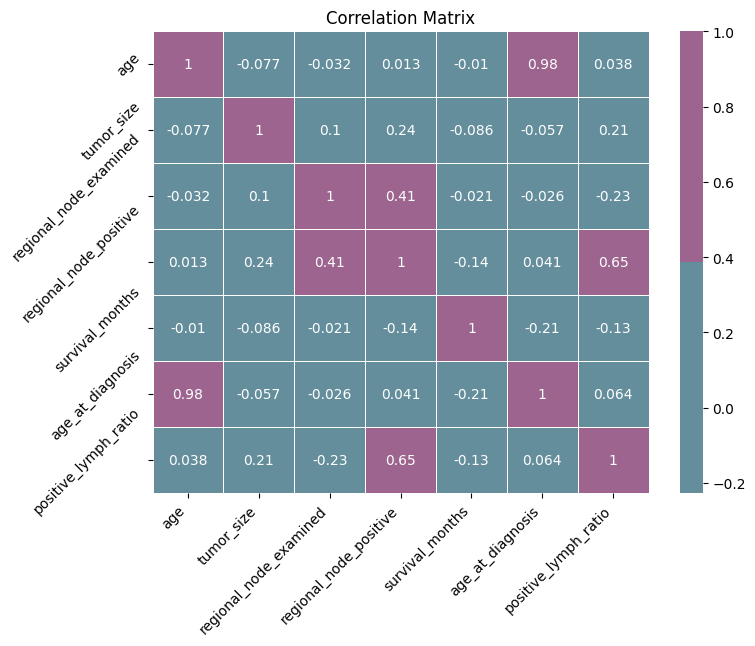

In [45]:
correlation_heatmap(breast_cancer)

In [46]:
breast_cancer = breast_cancer.drop(["regional_node_examined", "regional_node_positive"], axis=1)
breast_cancer.shape

(4019, 19)

***
# SECTION 2: Dataset Splits

## Resampling Protocol
In order to start the modeling process it is very important to split the dataset into training and test sets.

We will use two data partitions (`train` and `test`) and later on we will apply cross-validation over the train partition for deciding hyperparameters.

In [47]:
X = breast_cancer.loc[:, breast_cancer.columns != 'status']
y = breast_cancer['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

***
# SECTION 3: Data Preprocessing

For the preprocessing, we will firstly treat the non-normality of the `Tumor Size` variable by applying `BoxCox` transormation and then normalize the numerical variables with the usage of the `Min-max Scaler`, and finally `One-hot encoding` for the categorical varibles. It is very important to distinguish the preprocessing steps between the two sets, in order to avoid introducing bias. The goal is to simulate the testing of the model, with unseen data, as it will happen in a real-case scenario. The implementation of the following function, shows that we want the scaler to be fitted only with the data of the training set. Then this scaler is applied to the testing data as well.

## Transforming Tumor Size Variable

As previously mentioned in the `EDA-feature-extraction.ipynb`, we will apply the `BoxCox` trasformation on the `Tumor Size` variable of the dataset, separately for the training and test sets.

In [48]:
# Apply Box-Cox transformation to the "tumor_size" column in the training set
X_train['tumor_size'] = boxcox(X_train['tumor_size'])[0]

# Apply Box-Cox transformation to the "tumor_size" column in the test set
X_test['tumor_size'] = boxcox(X_test['tumor_size'])[0]

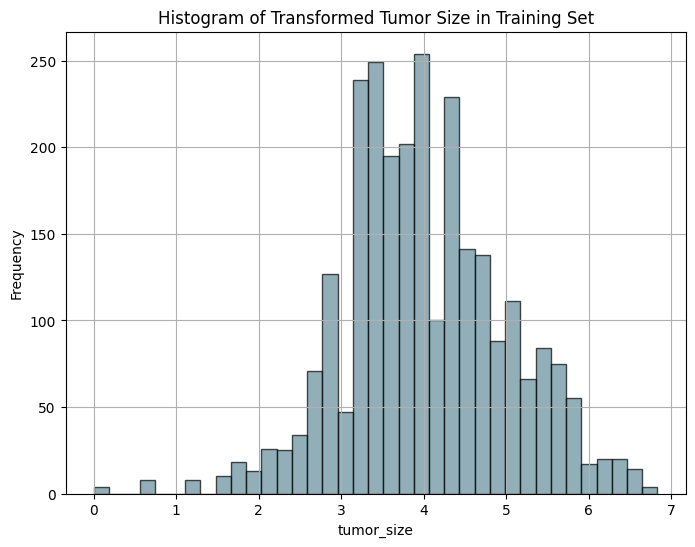

In [49]:
plot_histogram(X_train, 'tumor_size', '#648E9C', 'Histogram of Transformed Tumor Size in Training Set')

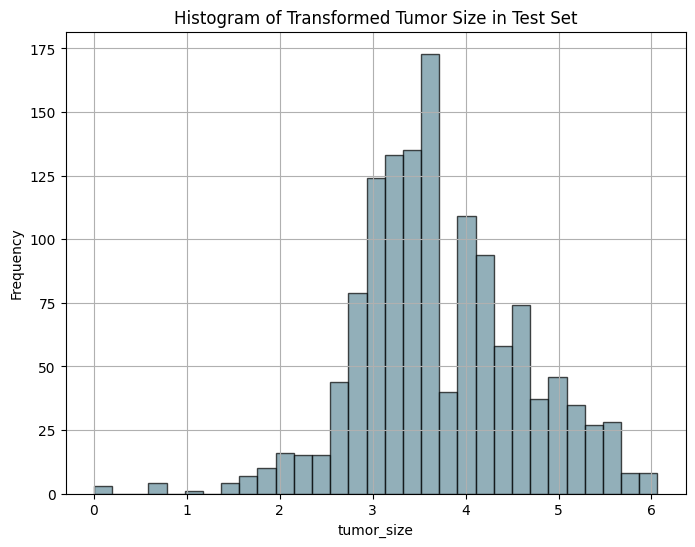

In [50]:
plot_histogram(X_test, 'tumor_size', '#648E9C', 'Histogram of Transformed Tumor Size in Test Set')

## Applying Preprocessing to Training and Testing Set

It is important to mention here, that after generating the final model, it is crucial to automate the process of preprocessing of the data, in order to be applied to the new unseen data so that they can be ingested by the model to produce the prediction of the target variable.

In [51]:
def preprocessing(X, y, scaler=None):
    print('Original shape:{}'.format(X.shape))
    categorical_columns =X.dtypes[X.dtypes == 'category'].index.values
    numerical_columns = [c for c in X.columns if c not in categorical_columns]
    
    # Scale numerical variables
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        #scaler = StandardScaler()
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    else: 
        X[numerical_columns] = scaler.transform(X[numerical_columns])
    
    # Apply one hot encoding to categorical variables
    for column in categorical_columns:
        X_one_hot = pd.get_dummies(X[column], prefix=column)
        X = X.merge(X_one_hot,left_index=True,right_index=True)
        X = X.drop(columns=[column])
    
    # Drop missings
    X=X.dropna()
    y=y[X.index]
    print('New shape:{}'.format(X.shape))
    return X, y, scaler


X_train, y_train, scaler = preprocessing(X_train,y_train)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

Original shape:(2692, 18)
New shape:(2692, 46)
Original shape:(1327, 18)
New shape:(1327, 46)


In [52]:
# Save preprocessed training set to CSV
# X_train.to_csv('preprocessed_train.csv', index=False)
# y_train.to_csv('preprocessed_train_labels.csv', index=False)

***
# SECTION 4 Modeling

## Cross-Validation, Model-Comparison & Hyper-parameter Tuning

In [53]:
np.random.seed(666)

# Apply Random Oversampling to balance the dataset
oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Define the models and their hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(solver='liblinear'), {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10],'class_weight': [None,'balanced']}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10],'class_weight': [None, 'balanced']}),
    'SVM': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'class_weight': ['balanced']}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01, 0.001],}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [5, 10], 'min_samples_split': [2, 5, 10],'class_weight': [None, 'balanced']}),
    'Naive Bayes': (GaussianNB(), {}),
}

# Define a custom scoring function to calculate precision, recall, F1-score
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='Alive'),
    'recall': make_scorer(recall_score, pos_label='Alive'),
    'f1_score': make_scorer(f1_score, pos_label='Alive')
}

# Perform cross-validation and hyperparameter tuning for each model
results = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='accuracy')
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the mean cross-validated scores for each metric
    cv_results = grid_search.cv_results_
    mean_scores = {
        'Accuracy': cv_results['mean_test_accuracy'][grid_search.best_index_],
        'Precision': cv_results['mean_test_precision'][grid_search.best_index_],
        'Recall': cv_results['mean_test_recall'][grid_search.best_index_],
        'F1-score': cv_results['mean_test_f1_score'][grid_search.best_index_]
    }
    
    results[model_name] = {
        'Best Hyperparameters': grid_search.best_params_,
        **mean_scores,
        'Validation Errors': cv_results['std_test_accuracy'][grid_search.best_index_]
    }

# Create a dataframe to store the results
df_results = pd.DataFrame(results).transpose()
df_results.index.name = 'Model'

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 300]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'class_weight': ['balanced'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [5, 10],
                         'min_samples_split': [2, 5, 10]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=GaussianNB(), param_grid={}, refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

In [54]:
df_results

,Best Hyperparameters,Accuracy,Precision,Recall,F1-score,Validation Errors
Model,,,,,,
Logistic Regression,"{'C': 1, 'class_weight': None, 'penalty': 'l1'}",0.797103,0.792764,0.804576,0.79855,0.010134
Random Forest,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.915019,0.909497,0.921833,0.915568,0.011617
SVM,"{'C': 10, 'class_weight': 'balanced', 'kernel'...",0.855073,0.864324,0.842774,0.853282,0.006828
Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 300}",0.901186,0.913674,0.886262,0.899721,0.013388
KNN,"{'n_neighbors': 3, 'weights': 'distance'}",0.901844,0.998383,0.805011,0.891281,0.005844
Decision Tree,"{'class_weight': None, 'max_depth': 10, 'min_s...",0.87725,0.89786,0.852016,0.873843,0.013492
Naive Bayes,{},0.684454,0.639645,0.845414,0.728181,0.00606


From the results of the `Cross-Validation` procedure, it is concluded that the most appropriate model for the specific use-case seems to be the `Random Forest` which achieves the highest value of `Recall` and `F1-score` respectively. It is really important, in this case, to achieve a high `Recall` value, since the model's goal is to classify unseen (future) patients with `Breast Cancer` into `Alive` or `Dead` cases.

In [55]:
df_results['Best Hyperparameters']['Random Forest']

{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200}


## Final Model

### Training-Test Error Analysis on the max_depth Parameter

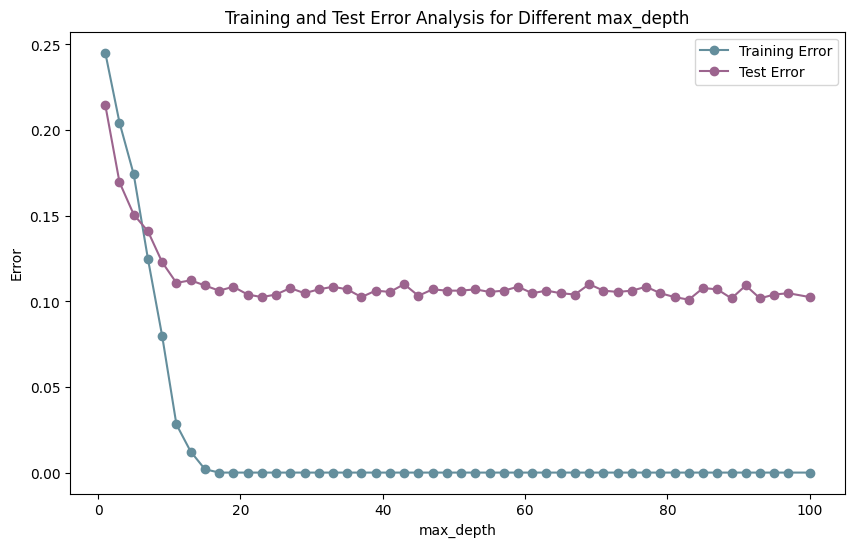

In [66]:
colors = ['#648E9C', '#9C648E']
# Generate 25 different values for max_depth
max_depth_values = np.linspace(1, 100, num=50, dtype=int)

# Initialize lists to store training and test errors
train_errors = []
test_errors = []

# Fit the model and calculate errors for different max_depth values
for max_depth in max_depth_values:
    # Create and fit the Random Forest model with the current max_depth value
    best_rf_model = RandomForestClassifier(class_weight='balanced', max_depth=max_depth, n_estimators=200)
    best_rf_model.fit(X_train_resampled, y_train_resampled);
    
    # Calculate training error
    train_pred = best_rf_model.predict(X_train_resampled)
    train_error = zero_one_loss(y_train_resampled, train_pred)
    train_errors.append(train_error)
    
    # Calculate test error
    test_pred = best_rf_model.predict(X_test)
    test_error = zero_one_loss(y_test, test_pred)
    test_errors.append(test_error)

# Plot the training and test errors
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_errors, marker='o', color=colors[0], label='Training Error')
plt.plot(max_depth_values, test_errors, marker='o', color=colors[1], label='Test Error')
plt.xlabel('max_depth')
plt.ylabel('Error')
plt.title('Training and Test Error Analysis for Different max_depth')
plt.legend()
plt.show();


Here it is obvious that when the parameter `max_depth` of the model exceeds a certain threshold (approx. **11**), the model is overfitting the data, leading to very small `training error` while the `test error` remains steady, or slightly increases. For that reason, we will try to train the algorithm with `max_depth` value equal to around **8** which seems *`just-right`*.

### Training-Test Error Analysis on the n_estimators Parameter

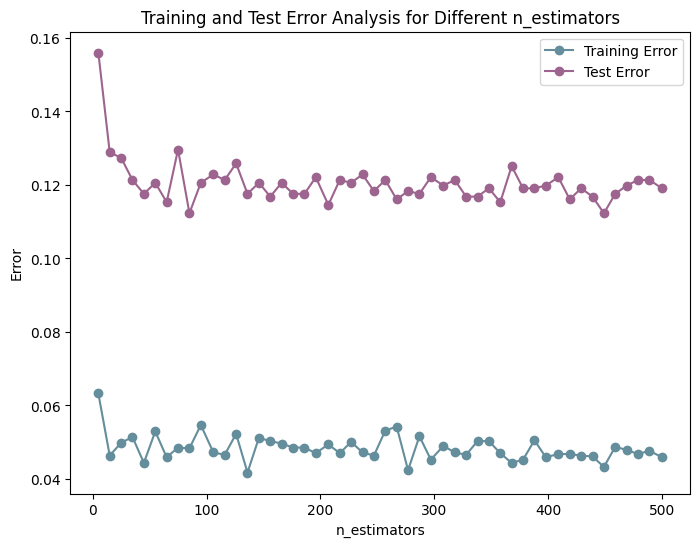

In [67]:
# Generate 25 different values for n_estimators
n_estimators_values = np.linspace(5, 500, num=50, dtype=int)

# Initialize lists to store training and test errors
train_errors = []
test_errors = []

# Fit the model and calculate errors for different n_estimators values
for n_estimators in n_estimators_values:
    # Create and fit the Random Forest model with the current n_estimators value
    best_rf_model = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=n_estimators)
    best_rf_model.fit(X_train_resampled, y_train_resampled)
    
    # Calculate training error
    train_pred = best_rf_model.predict(X_train_resampled)
    train_error = zero_one_loss(y_train_resampled, train_pred)
    train_errors.append(train_error)
    
    # Calculate test error
    test_pred = best_rf_model.predict(X_test)
    test_error = zero_one_loss(y_test, test_pred)
    test_errors.append(test_error)

# Plot the training and test errors
plt.figure(figsize=(8, 6))
plt.plot(n_estimators_values, train_errors, marker='o', color=colors[0], label='Training Error')
plt.plot(n_estimators_values, test_errors, marker='o', color=colors[1], label='Test Error')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.title('Training and Test Error Analysis for Different n_estimators')
plt.legend()
plt.show();

As for the `n_estimators` parameter of the model, the result is not so obvious. It seems that over the whole range of the parameter, from **5** to **500**,  both the `training error` and the `test error` remain approximately constant. Thus a clear conclusion cannot be made from this figure.

### Training-Test Error Analysis on the Training Data Size

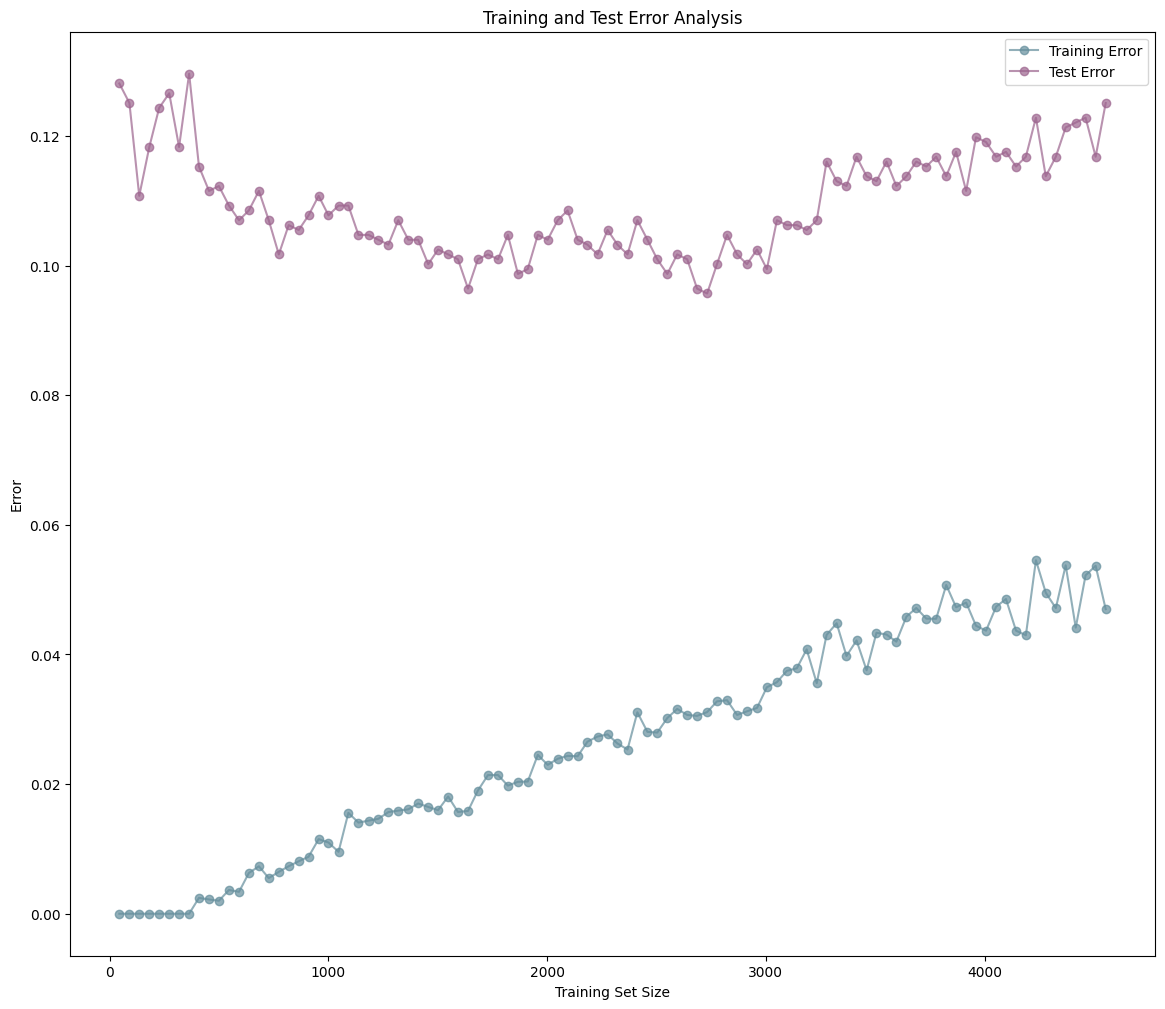

In [69]:
# Define the best hyperparameters for Random Forest
best_rf_params = {'class_weight': 'balanced','max_depth': 10, 'n_estimators': 200}

# Create and fit the best Random Forest model
best_rf_model = RandomForestClassifier(**best_rf_params)

# Initialize lists to store training and test errors
train_errors = []
test_errors = []
train_sizes = []

# Vary the size of the training set
for i in range(1, 101, 1):
    train_size = int((i / 100) * len(X_train_resampled))
    train_sizes.append(train_size)
    
    # Fit the model on the current training set size
    best_rf_model.fit(X_train_resampled[:train_size], y_train_resampled[:train_size])
    
    # Calculate training error
    train_pred = best_rf_model.predict(X_train_resampled[:train_size])
    train_error = zero_one_loss(y_train_resampled[:train_size], train_pred)
    train_errors.append(train_error)
    
    # Calculate test error
    test_pred = best_rf_model.predict(X_test)
    test_error = zero_one_loss(y_test, test_pred)
    test_errors.append(test_error)

# Plot the training and test errors
plt.figure(figsize=(14, 12))
plt.plot(train_sizes, train_errors, marker='o', alpha=0.7, color=colors[0], label='Training Error')
plt.plot(train_sizes, test_errors, marker='o', alpha=0.7, color=colors[1], label='Test Error')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Training and Test Error Analysis')
plt.legend()
plt.show();

From this plot, one can understand that as the `Training Set Size` which is fed into the model increases, the `training misslcassification error` increases but very slightly, since the worst error achieved is approx. 0.06. As for the `test misslcassification error`, it is clear that in fluctuates between the values **0.10** and **0.12**. However, the slopes of the figure suggest that by increasing the total size of the dataset, would lead the two curves to come closer and closer, meaning that the model would be able to generalize pretty-well.

### Final Performace Metrics

Although, previously it was mentioned that a value of **8** for the variable `max_depth` might lead to a more robust solution, for now, we consider keeping it equal to 10, since we retrieve better results on the unseen dataset. However, in future work this might need to be investigated further.

Random Forest Classifier - Test Results
---------------------------------
Accuracy: 0.8809
Precision: 0.9361
Recall: 0.9228
F1-score: 0.9294
---------------------------------
Confusion Matrix:
Predicted Value  Alive  Dead
True Value                  
Alive             1040    87
Dead                71   129


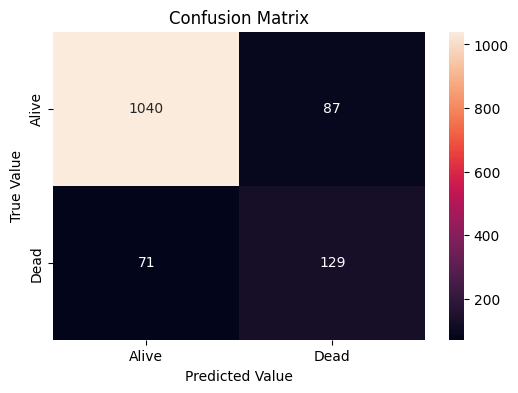

In [59]:
# Define the best hyperparameters for Random Forest
best_rf_params = {'class_weight': 'balanced','max_depth': 10, 'n_estimators': 200}

# Create and fit the best Random Forest model
best_rf_model = RandomForestClassifier(**best_rf_params)

# Fit the model and obtain the training and validation loss
best_rf_model.fit(X_train_resampled, y_train_resampled)

# Use the fitted model to make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the performance of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Alive')
recall = recall_score(y_test, y_pred, pos_label='Alive')
f1 = f1_score(y_test, y_pred, pos_label='Alive')
confusion_mat = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['Alive', 'Dead']

# Create a labeled confusion matrix with indicators
confusion_mat_labeled = pd.DataFrame(confusion_mat, index=class_labels, columns=class_labels)
confusion_mat_labeled.index.name = 'True Value'
confusion_mat_labeled.columns.name = 'Predicted Value'

# Print the performance metrics and labeled confusion matrix
print("Random Forest Classifier - Test Results")
print("---------------------------------")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("---------------------------------")
print("Confusion Matrix:")
print(confusion_mat_labeled)


# Plot the labeled confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_labeled, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show();


### Interpretability of the Final Model

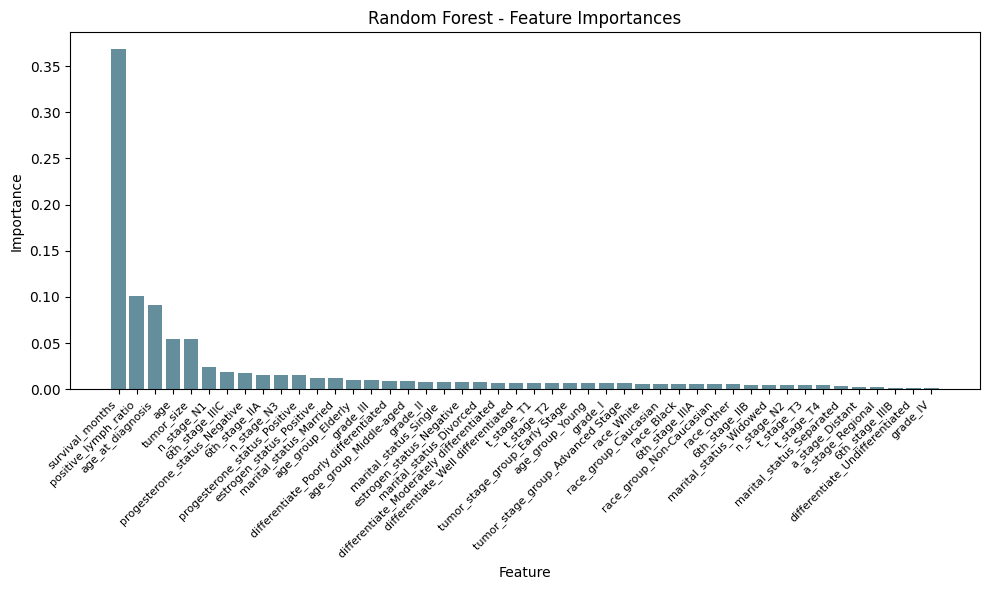

In [60]:
# Get feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

# Get the names of the features
feature_names = X_train.columns[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), sorted_feature_importances, color='#648E9C')
plt.xticks(range(len(feature_importances)), feature_names, rotation=45, ha='right', fontsize=8)
plt.title('Random Forest - Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show();

From this figure, it is clear that the most important feature included in the final model is by far `survival_months`. Following by, `positive_lymph_ratio` and `age_at_diagnosis` play a crucial role in the predictability power of the model. Moreover, `tumor_size` and `n_stage_N1` offer discrimination power to the learning algorithm enabling it to distinguish between `Alive` and `Dead` cases. Lastly, `n_stage_N3`, `progesterone_status_negative`, `6th_stage_ICC` and `progesterone_status_negative` are the next in the feature importance list. The rest of the variables contribute quite less than the mentioned ones.

Important notes to mention here is:
- It is obvious that there is some overlap between specific variables used during the training of the algorithm (`age` and `age_at_diagnosis`)
- Some of the categories included in the architecture, do not contribute as much in deriving decisions on unseen data.
    - However, since in this case the computation power needed to fit the algorithm and perform computational expensive processes such as Cross-Validation, was clearly bearable, we did not pay special attention to reduce the dimensionality of the model.
    - Although, dimensionality techniques, such as `PCA/MCA/MFA` would solve this problem, and would make the size and complexity of the model drop.
    - Also with the following commands, it is easy to see (from the `csv` file `chi-2-2`) which categories of the categorical variables are statistically correlated.

In [61]:
_, cat_cols = split_cat_num_columns(X_train)
chi_squared_results = perform_chi_squared_test(X_train, cat_cols)

In [62]:
# Filter out duplicate rows
chi_squared_results_unique = chi_squared_results[chi_squared_results['P-value'] < 0.05]

# Sort Variable 1 and Variable 2 in each row
sorted_variables = np.sort(chi_squared_results_unique[['Variable 1', 'Variable 2']], axis=1)
chi_squared_results_unique.loc[:, ['Variable 1', 'Variable 2']] = sorted_variables

# Drop duplicate rows
chi_squared_results_unique = chi_squared_results_unique.drop_duplicates(subset=['Variable 1', 'Variable 2'])

# Save the results to a CSV file
chi_squared_results_unique.to_csv("./chi-2-2.csv", index=False)

In [63]:
# from sklearn import tree
# # Get the list of all trees in the Random Forest
# trees = best_rf_model.estimators_

# # Plot all the trees
# for i, tree_estimator in enumerate(trees):
#     plt.figure(figsize=(10, 6))
#     tree.plot_tree(tree_estimator, feature_names=X_train.columns, filled=True)
#     plt.title("Tree {}".format(i+1))
#     plt.show();

### Saving the Final Model

In [64]:
# Save the best_rf_model to a file
with open("best_rf_model.pkl", "wb") as file:
    pickle.dump(best_rf_model, file)